<a href="https://colab.research.google.com/github/DNAsantanu/ML-Projects/blob/main/Image_Classification_using_CNN_(Programming_Assignment_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Roll No.-MA24M021
## Name - Santanu Das

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Checking if GPU is avalible in the device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


### Information about the GPU and CPU and the Number of cores it uses

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    # Get GPU properties
    gpu_index = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(gpu_index)
    multi_processor_count = torch.cuda.get_device_properties(gpu_index).multi_processor_count
    cuda_cores = multi_processor_count * 128  # Approximation (varies by architecture)

    print(f"Using device: {gpu_name}")
    print(f"CUDA cores: {cuda_cores}")
else:
    device = torch.device("cpu")
    print("Using device: CPU")


Using device: NVIDIA GeForce GTX 1650
CUDA cores: 1792


In [ ]:
import multiprocessing
print(f"CPU Cores Available: {multiprocessing.cpu_count()}")


CPU Cores Available: 12


#### Hyperparameters (for experimenting with different learning rates, batch sizes and number fo training epochs to find out the best values of the hyperparameters)

## 1. batch_size

In [ ]:
batch_size = 128

##### Loading the train and test dataset of CIFAR-10 and using "transform", firstly convert the images from Python Image Library or Numpy arrays to Pytorch tensors and also changes the image format from (H,W,C) to (C,H,W) because Pytorch expects the channels-first.
##### And secondly, use normalization using mean=0.5 and Standard deviation = 0.5 for the there R,G,B channels which scales the input values from (range[0.0,0.1]) to (range[-1,1]) (Zero centered data is beneficial for models when using BatchNorm and ReLU).
##### Then, i have used the "DataLoader" to arrange the data into different batch sizes, and "shuffle=True" whcih randomly shuffles the dataset at the start of every epoch(it helps to prevent overfitting by ensuring that the model doesn't learn the order of the data) and  used "num_workers=6" for faster data loading ( num_workers = (CPU cores)//2) and "pin_memory=True" to speeds up data transfer from CPU to the GPU.


In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6,pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
train_dataset_size = len(train_dataset)
train_dataset_size

50000

#### Defining the VGG11 architectures

In [ ]:
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10),  # Assuming 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Instantiate the improved model
model = VGG11()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model initialized and moved to", device)


Model initialized and moved to cuda


### VGG11 with Batch_normalization

In [ ]:
class VGG11_BN(nn.Module):
    def __init__(self):
        super(VGG11_BN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (64, 16, 16)

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (128, 8, 8)

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (256, 4, 4)

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (512, 2, 2)

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (512, 1, 1)
        )

        # Remove AdaptiveAvgPool2d and adjust the FC layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),  # Input size: 512 * 1 * 1
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(4096, 10),  # Output size: 10 classes
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)  # Output: (batch_size, 512, 1, 1)
        x = torch.flatten(x, 1)  # Flatten to (batch_size, 512 * 1 * 1)
        x = self.classifier(x)  # Pass through FC layers
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

# Instantiate the model
model = VGG11_BN()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model initialized and moved to", device)

Model initialized and moved to cuda


## 2. Learning rate (Hyperparameter)

In [ ]:
learning_rate = 0.0001

##### This is a multi-class classification problem so we use the CrossEntropyLoss and Stochastic(random) Gradient descent with a mini-batch of 64 and also "Nesterov = True" (to see the next step before moving forward) and also the weight_decay to prevent the noisy effect of the Large weights and keep the step small.

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,nesterov=True,weight_decay=1e-5)



#### 3. Number of epochs (Hyperparameter)

In [ ]:
num_epochs = 150

### Training the model

In [ ]:
import time

# Training loop
train_losses, val_losses, accuracies = [], [], []

for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch

    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        # Convert NumPy arrays to tensors if needed
        if isinstance(inputs, np.ndarray):
            inputs = torch.from_numpy(inputs)
        if isinstance(labels, np.ndarray):
            labels = torch.from_numpy(labels)

        # Move tensors to CUDA
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Convert NumPy arrays to tensors if needed
            if isinstance(inputs, np.ndarray):
                inputs = torch.from_numpy(inputs)
            if isinstance(labels, np.ndarray):
                labels = torch.from_numpy(labels)

            # Move tensors to CUDA
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Logging losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(test_loader))
    accuracies.append(100 * correct / total)

    end_time = time.time()  # End time for the epoch
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Accuracy: {accuracies[-1]:.2f}%, "
          f"Time: {epoch_duration:.2f} sec")


Epoch 1/150, Train Loss: 4.4664, Val Loss: 1.5372, Accuracy: 44.55%, Time: 95.35 sec
Epoch 2/150, Train Loss: 1.6195, Val Loss: 1.3772, Accuracy: 49.86%, Time: 87.09 sec
Epoch 3/150, Train Loss: 1.4519, Val Loss: 1.3223, Accuracy: 52.76%, Time: 89.56 sec
Epoch 4/150, Train Loss: 1.3437, Val Loss: 1.2525, Accuracy: 55.31%, Time: 100.47 sec
Epoch 5/150, Train Loss: 1.2621, Val Loss: 1.2145, Accuracy: 56.07%, Time: 96.24 sec
Epoch 6/150, Train Loss: 1.1846, Val Loss: 1.1739, Accuracy: 58.46%, Time: 89.93 sec
Epoch 7/150, Train Loss: 1.1253, Val Loss: 1.1432, Accuracy: 59.65%, Time: 87.53 sec
Epoch 8/150, Train Loss: 1.0564, Val Loss: 1.1258, Accuracy: 60.32%, Time: 87.38 sec
Epoch 9/150, Train Loss: 1.0025, Val Loss: 1.0966, Accuracy: 62.06%, Time: 87.11 sec
Epoch 10/150, Train Loss: 0.9391, Val Loss: 1.0877, Accuracy: 62.40%, Time: 87.78 sec
Epoch 11/150, Train Loss: 0.8860, Val Loss: 1.0784, Accuracy: 62.47%, Time: 87.71 sec
Epoch 12/150, Train Loss: 0.8282, Val Loss: 1.0622, Accuracy: 

#### Ploting the training and validation loss and accuracy

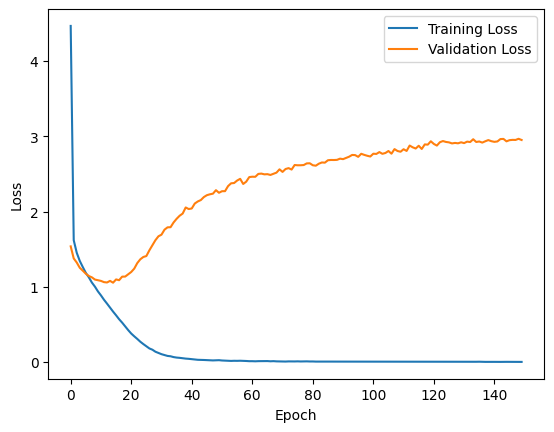

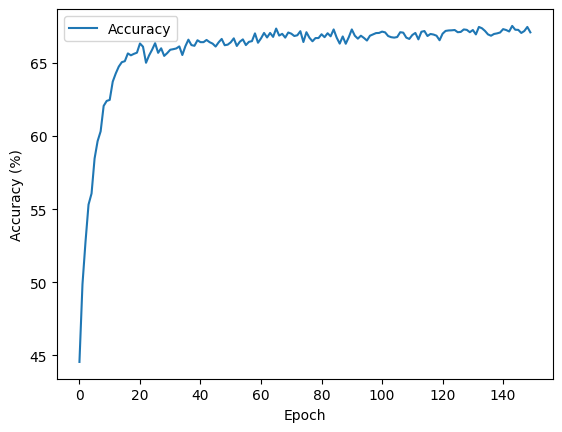

In [ ]:
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()



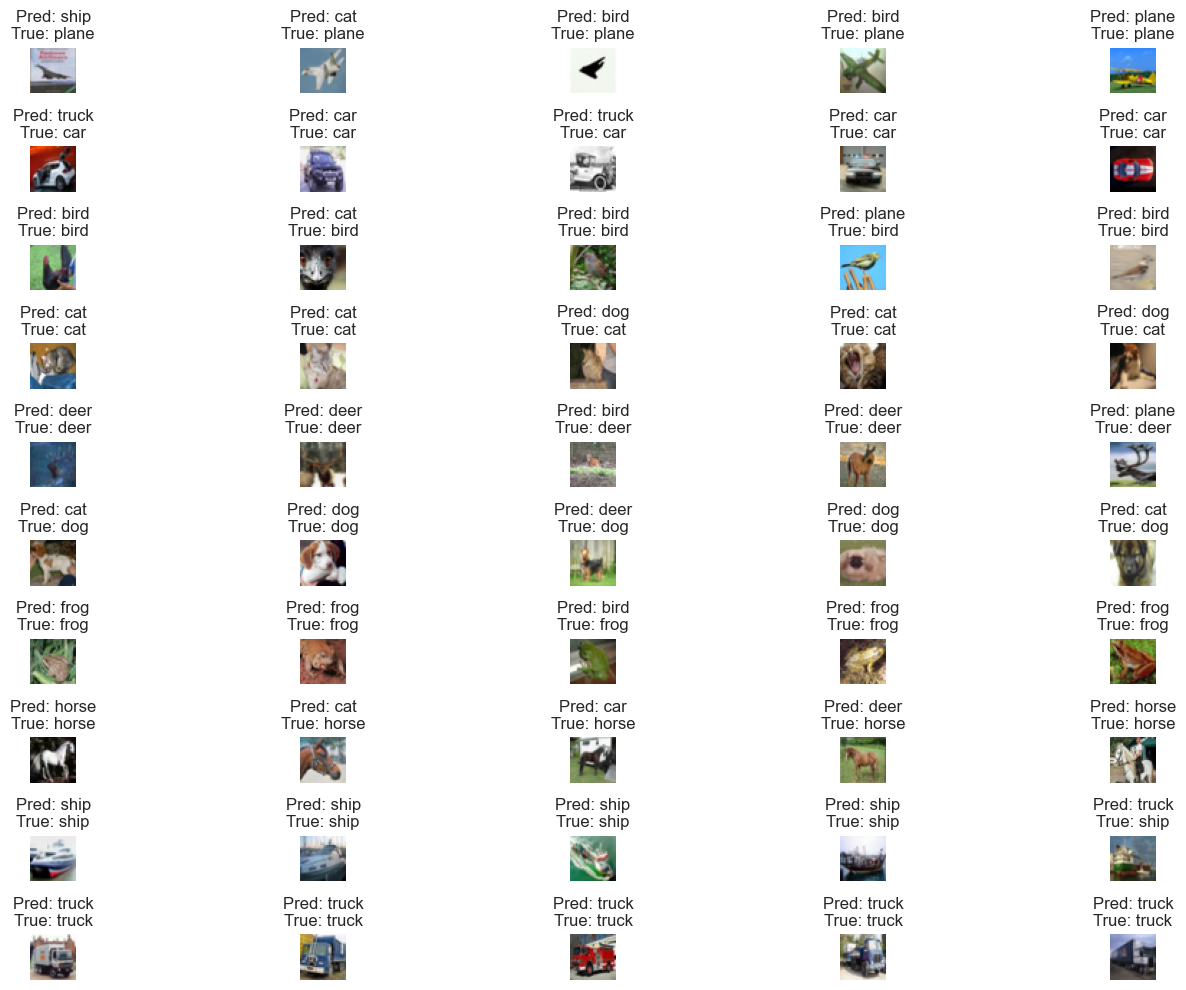

In [ ]:
# Function to display images with predictions
def display_images_with_predictions(model, test_loader, classes, num_images_per_class=5):
    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device  # Get the device of the model

    # Dictionary to store images and labels for each class
    class_images = {class_name: [] for class_name in classes}

    # Iterate through the test dataset and collect images
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(images)):
                class_name = classes[labels[i]]
                if len(class_images[class_name]) < num_images_per_class:
                    class_images[class_name].append((images[i].cpu(), predicted[i].item(), labels[i].item()))

            # Stop if we have enough images for each class
            if all(len(images) >= num_images_per_class for images in class_images.values()):
                break

    # Plot the images
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(classes):
        for j, (image, pred, label) in enumerate(class_images[class_name]):
            # Convert image tensor to numpy array and denormalize
            image = image.permute(1, 2, 0).numpy()
            image = image * 0.5 + 0.5  # Denormalize (since we normalized to [-1, 1])

            # Plot the image
            plt.subplot(len(classes), num_images_per_class, i * num_images_per_class + j + 1)
            plt.imshow(image)
            plt.title(f'Pred: {classes[pred]}\nTrue: {classes[label]}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()


# Define the class names for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Display visual results for five test images per class
display_images_with_predictions(model, test_loader, classes, num_images_per_class=5)

### Re-set the model's Weights and parameters

In [ ]:
def reset_model_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()  # Reset weights

reset_model_weights(model)
